Import Libraries

In [ ]:
import tensorflow as tf
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
from keras import layers, models
import pathlib
import os
import cv2
import string
from keras.metrics import Accuracy, Precision, Recall
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import confusion_matrix, precision_score, recall_score
from sklearn.metrics import f1_score
import seaborn as sns
import pandas as pd

Importing Dataset

In [ ]:
class readDataset:
    def __init__(self, datasetpath, imageShape):
        self.datasetpath = datasetpath
        self.imageShape = imageShape
    def imagesPath(self, folder, name):
        images = list(pathlib.Path(os.path.join(self.datasetpath,
                                                folder)).glob('*{}.*'.format(name)))
        return images
    def readImages(self, images, channels):
        listImages = []
        images = np.sort(images)
        for image in images:
            image = tf.io.read_file(str(image))
            image = tf.image.decode_png(image, channels = channels)
            image = tf.image.resize(image, self.imageShape)
            image/= 255
            listImages.append(image)
        return listImages
    def allDataset(self, label):
      images = self.readImages(self.imagesPath(label, name = ')'), channels = 3)
      masks = np.array(self.readImages(self.imagesPath(label, name = 'mask'), channels = 1))
      masks = (masks >= 0.5).astype('int32')
      return np.array(images), masks
    def finalDataset(self, labels):
        images_benign, masks_benign = self.allDataset(labels[0])
        images_malignant, masks_malignant = self.allDataset(labels[1])
        images_normal, masks_normal = self.allDataset(labels[2])
        images = np.vstack([images_benign, images_malignant, images_normal])
        masks = np.vstack([masks_benign, masks_malignant, masks_normal])
        labels = np.hstack([np.ones(shape = (len(images_benign),))*0,
                           np.ones(shape = (len(images_malignant), ))*1,
                           np.ones(shape = (len(images_normal), ))*2])
        return images, masks, labels

    def dataAugmentation(self, images, masks, labels):
      imagesupdate = []
      masksupdate = []
      labelsupdate = []
      for image, mask, label in zip(images, labels, masks):
            image1 = tf.image.adjust_contrast(image, contrast_factor = 2)
            image2 = tf.image.adjust_brightness(image, delta = 0.3)
            imagesupdate.append(image), masksupdate.append(mask), labelsupdate.append(label)
            imagesupdate.append(image1), masksupdate.append(mask), labelsupdate.append(label)
            imagesupdate.append(image2), masksupdate.append(mask), labelsupdate.append(label)
      return np.array(imagesupdate), np.array(masksupdate), np.array(labelsupdate)

In [ ]:
datasetpath = '/content/drive/MyDrive/cancer/Dataset_BUSI_with_GT'
datasetObject = readDataset(datasetpath, [128, 128])
images, masks, labels = datasetObject.finalDataset(['benign', 'malignant', 'normal'])

Data PreProcessing

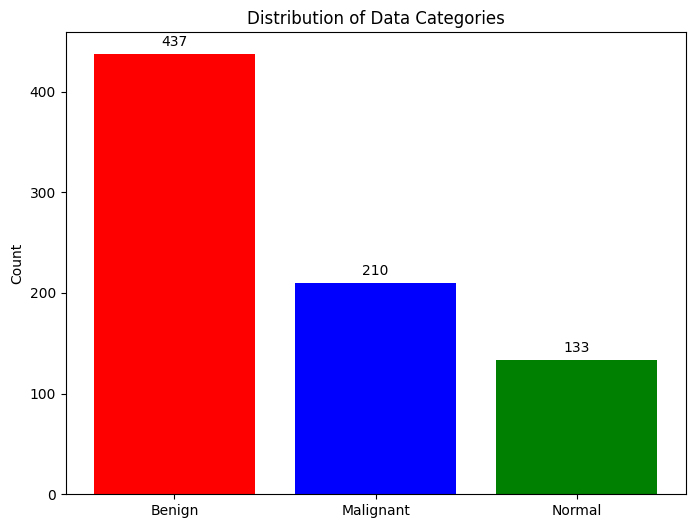

In [ ]:
import matplotlib.pyplot as plt
from collections import Counter

label_counts = Counter(labels)

categories = list(label_counts.keys())
category_counts = list(label_counts.values())

plt.figure(figsize=(8, 6))
bars = plt.bar(categories, category_counts, color=['red', 'blue', 'green'])
plt.ylabel('Count')
plt.title('Distribution of Data Categories')

for bar, count in zip(bars, category_counts):
    plt.text(bar.get_x() + bar.get_width() / 2, count + 5, str(count), ha='center', va='bottom')

# Set X-axis labels
plt.xticks(categories, ['Benign', 'Malignant', 'Normal'])

plt.show()

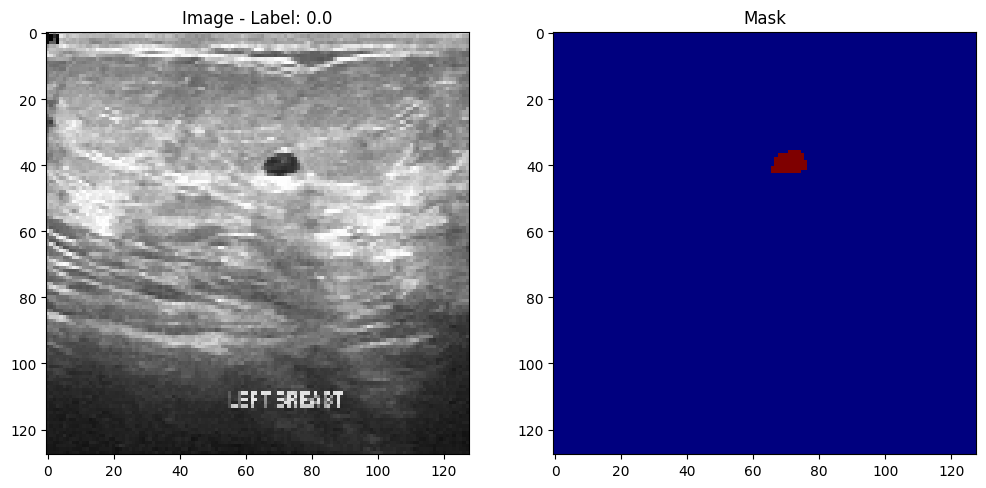

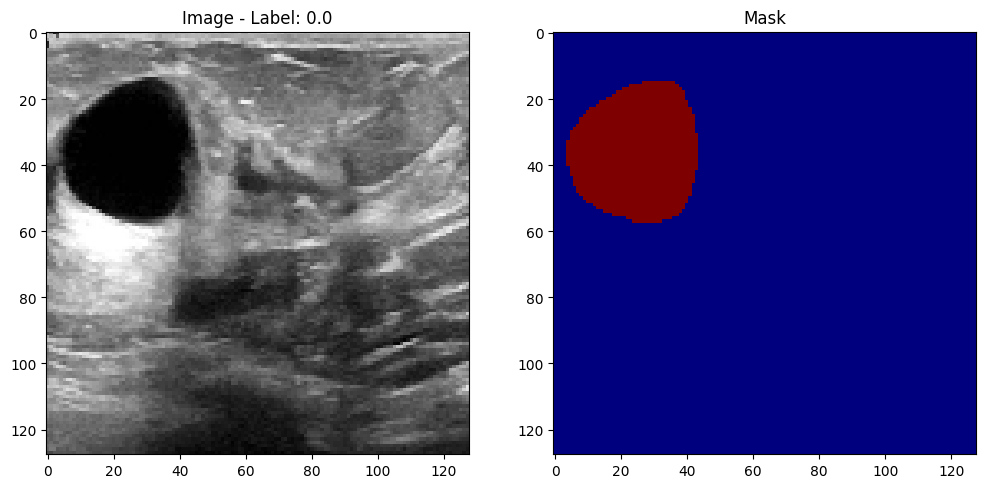

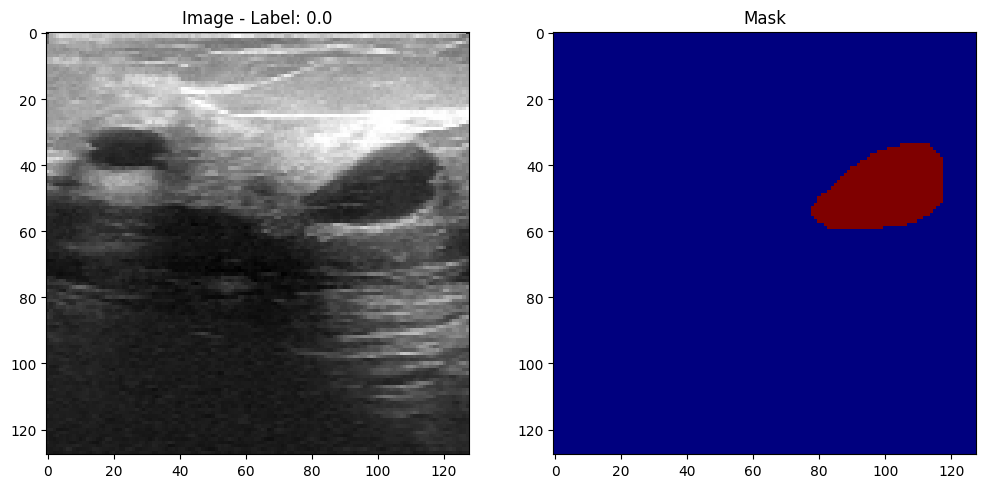

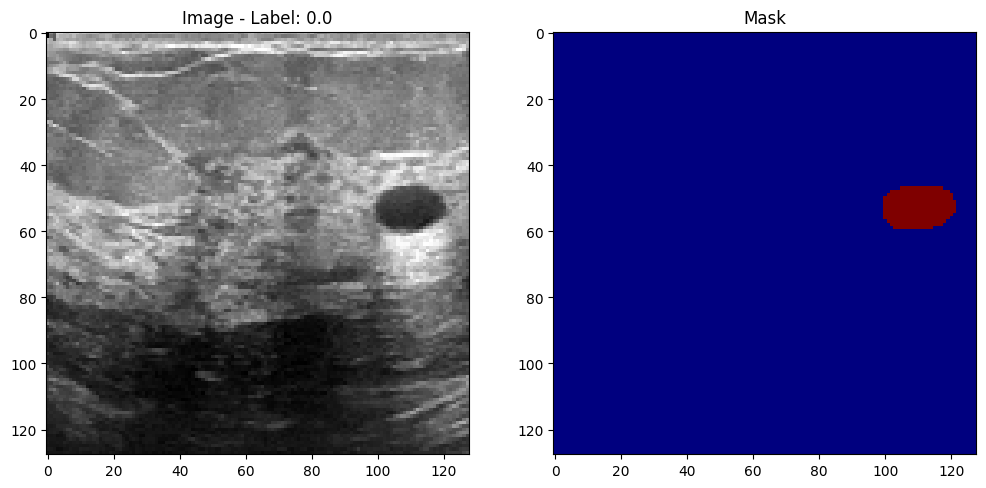

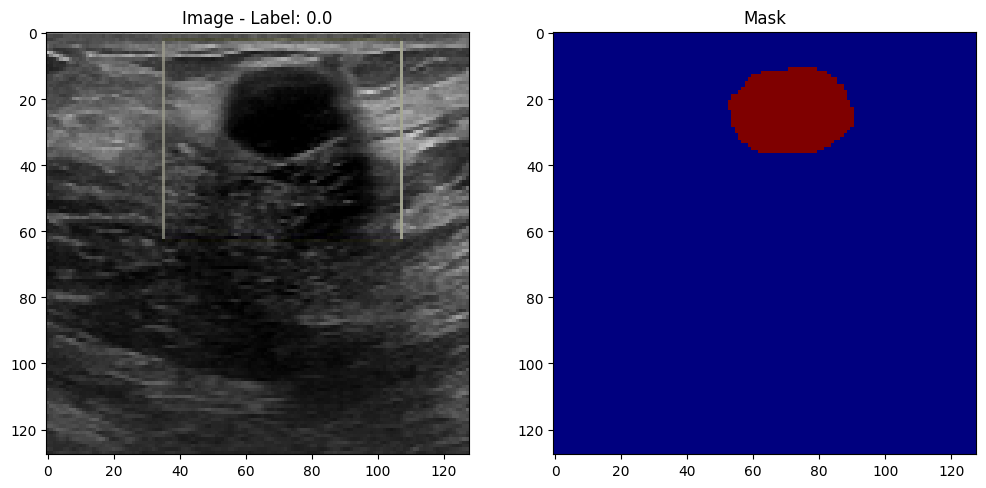

In [ ]:
num_samples_to_plot = 5
for i in range(num_samples_to_plot):
    plt.figure(figsize=(12, 6))

    # ultrasound
    plt.subplot(1, 2, 1)
    plt.imshow(images[i], cmap='gray')
    plt.title(f'Image - Label: {labels[i]}')

    # mask
    if masks is not None:
        plt.subplot(1, 2, 2)
        plt.imshow(masks[i], cmap='jet')
        plt.title('Mask')

    plt.show()


In [ ]:
images, masks, labels = datasetObject.dataAugmentation(images, labels, masks)
images.shape, masks.shape, labels.shape

((2340, 128, 128, 3), (2340, 128, 128, 1), (2340,))

In [ ]:
np.unique(labels, return_counts = True)

(array([0., 1., 2.]), array([1311,  630,  399]))

Visualize Dataset

In [ ]:
def showImagesWithMask(images, masks, labels):
    plt.figure(figsize = (12, 12))
    for i in range(len(images)):
        plt.subplot(8, 8, (i + 1))
        plt.imshow(images[i])
        plt.imshow(masks[i], alpha = 0.3, cmap = 'jet')
        plt.title(labels[i])
    plt.legend()

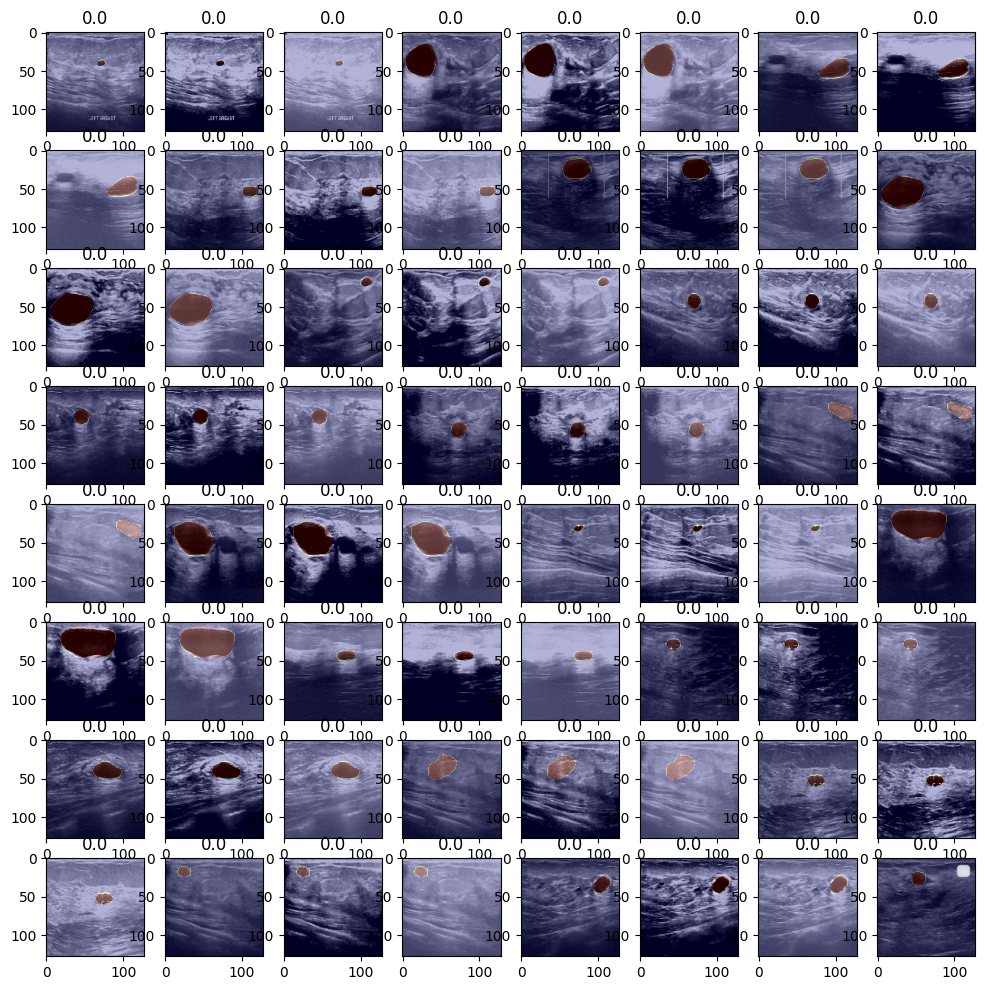

In [ ]:
showImagesWithMask(images[:64], masks[:64], labels[:64])

Splitting the Dataset

In [ ]:
randomIndexs = np.random.randint(0, len(images), size = (len(images), ))
images = images[randomIndexs]
masks = masks[randomIndexs]
labels = labels[randomIndexs]
images.shape, masks.shape, labels.shape

((2340, 128, 128, 3), (2340, 128, 128, 1), (2340,))

In [ ]:
valid = 500
trainDataset = [images[:images.shape[0] - valid],
         masks[:images.shape[0] - valid],
         labels[:images.shape[0] - valid]]
validDataset = [images[images.shape[0] - valid:],
         masks[images.shape[0] - valid:],
         labels[images.shape[0] - valid:]]

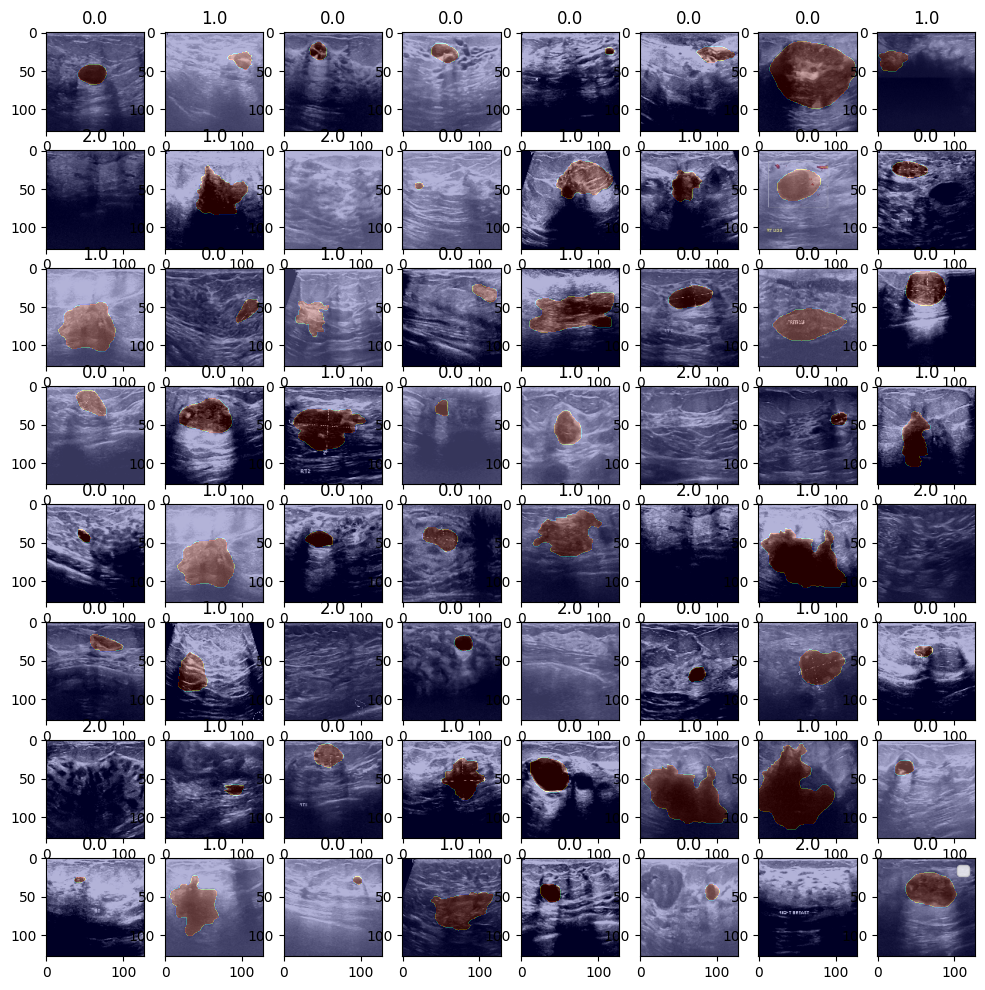

In [ ]:
showImagesWithMask(trainDataset[0][:64], trainDataset[1][:64], trainDataset[2][:64])

Artificial Neural Network


In [ ]:
def convolution(inputs, padding, strides, filter, kernel_size):
    x = inputs
    y = layers.Conv2D(filter, kernel_size = 1, padding = padding,
                     strides = strides,
                     kernel_regularizer = tf.keras.regularizers.L2(0.001))(x)
    x = layers.Conv2D(filter, kernel_size = kernel_size, padding = padding,
                     strides = strides,
                     kernel_regularizer = tf.keras.regularizers.L2(0.001))(y)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Conv2D(filter, kernel_size = kernel_size, padding = padding,
                     strides = strides,
                     kernel_regularizer = tf.keras.regularizers.L2(0.001))(x)
    x = layers.BatchNormalization()(x)
    x = layers.add([x, y])
    x = layers.Activation('relu')(x)
    return x

In [ ]:
def encoder(inputs, filter):
    correlation = convolution(inputs, padding = 'same', strides = 1, filter = filter,
                             kernel_size = 5)
    downsample = layers.AveragePooling2D()(correlation)
    return correlation, downsample

In [ ]:
def decoder(inputs, skip_connection, filter):
    upsample = layers.Conv2DTranspose(filter, 5, padding = 'same', strides = 2,
                                     kernel_regularizer = tf.keras.regularizers.L2(0.001))(inputs)
    upsample = layers.Activation('relu')(upsample)
    upsample = layers.BatchNormalization()(upsample)
    connection = layers.average([upsample, skip_connection])
    correlation = convolution(connection, padding = 'same', strides = 1, filter = filter,
                             kernel_size = 5)
    return correlation

Model Summary

In [ ]:
input = layers.Input(shape = (128, 128, 3))
filter = 32
corr1, downsample1 = encoder(input, filter)
corr2, downsample2 = encoder(downsample1, filter*2)
corr3, downsample3 = encoder(downsample2, filter*4)
corr4, downsample4 = encoder(downsample3, filter*8)
downsample4 = convolution(downsample4, padding = 'same', strides = 1, filter = filter*8,
                         kernel_size = 5)
features_vector_1 = layers.GlobalAveragePooling2D()(downsample4)
features_vector_2 = layers.Flatten()(downsample4)
features_vector_2 = layers.Dropout(0.5)(features_vector_2)
features_vector_1 = layers.Dropout(0.5)(features_vector_1)
encoder_x = layers.Dense(64, name = 'latent_space',
                kernel_regularizer = tf.keras.regularizers.L2(0.001))(features_vector_1)
x = layers.Dense(downsample4.shape[1]*downsample4.shape[2]*downsample4.shape[3],
                kernel_regularizer = tf.keras.regularizers.L2(0.001))(encoder_x)
x = layers.Reshape((downsample4.shape[1], downsample4.shape[2], downsample4.shape[3]),
                  name = 'reshape')(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.4)(x)
decoder_corr1 = decoder(x, corr4, filter*8)
decoder_corr2 = decoder(decoder_corr1, corr3, filter*4)
decoder_corr3 = decoder(decoder_corr2, corr2, filter*2)
decoder_corr4 = decoder(decoder_corr3, corr1, filter)
output = layers.Conv2DTranspose(1, 5, padding = 'same', strides = 1)(decoder_corr4)
output = layers.Activation('sigmoid', name = 'UNET')(output)
labelOutput = layers.Dense(32, activation = 'relu')(features_vector_2)
labelOutput = layers.BatchNormalization()(labelOutput)
labelOutput = layers.Dropout(0.5)(labelOutput)
labelOutput = layers.Dense(16, activation = 'relu')(labelOutput)
labelOutput = layers.BatchNormalization()(labelOutput)
labelOutput = layers.Dropout(0.5)(labelOutput)
labelOutput = layers.Dense(1, name = 'label')(labelOutput)

m = models.Model(inputs = input, outputs = [output, labelOutput])

m.compile(loss = [tf.keras.losses.BinaryFocalCrossentropy(), 'mae'],
          optimizer = tf.keras.optimizers.Adam(learning_rate = 0.00001),
          metrics = ['accuracy', Precision(name = 'precision'), Recall(name = 'recall')],
          )
m.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 128, 128, 32)         128       ['input_1[0][0]']             
                                                                                                  
 conv2d_1 (Conv2D)           (None, 128, 128, 32)         25632     ['conv2d[0][0]']              
                                                                                                  
 batch_normalization (Batch  (None, 128, 128, 32)         128       ['conv2d_1[0][0]']            
 Normalization)                                                                               

Plot the Model Structure

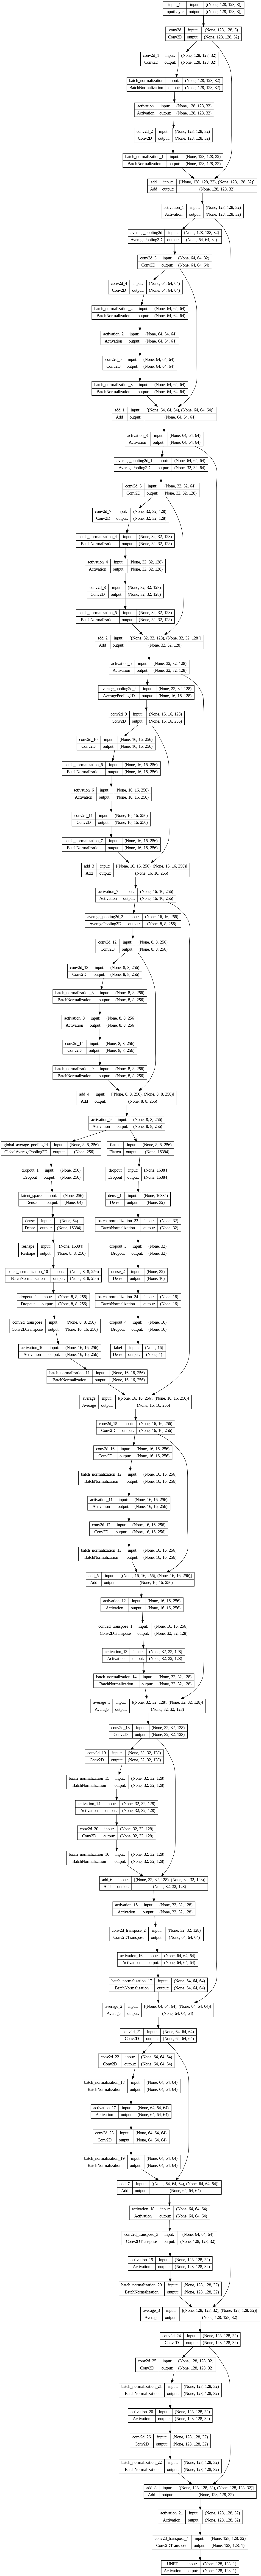

In [ ]:
tf.keras.utils.plot_model(m,
                            show_shapes=True,
                            show_layer_names=True,)

Fit the Model

In [ ]:
history = m.fit(trainDataset[0], [trainDataset[1], trainDataset[2]], epochs = 10,
               validation_data = (validDataset[0], [validDataset[1], validDataset[2]]),
               batch_size = 8, callbacks = [
                   tf.keras.callbacks.EarlyStopping(patience = 12, monitor = 'val_loss',
                                                   mode = 'min', restore_best_weights = True)
               ])

Epoch 1/10
230/230 [==============================] - 70s 153ms/step - loss: 6.3733 - UNET_loss: 0.2706 - label_loss: 1.9056 - UNET_accuracy: 0.4987 - UNET_precision: 0.0828 - UNET_recall: 0.5376 - label_accuracy: 0.4304 - label_precision: 0.4528 - label_recall: 0.3967 - val_loss: 5.2225 - val_UNET_loss: 0.1530 - val_label_loss: 0.9467 - val_UNET_accuracy: 0.7231 - val_UNET_precision: 0.0632 - val_UNET_recall: 0.1788 - val_label_accuracy: 0.5380 - val_label_precision: 0.6667 - val_label_recall: 0.0086
Epoch 2/10
230/230 [==============================] - 34s 147ms/step - loss: 6.0232 - UNET_loss: 0.0975 - label_loss: 1.8944 - UNET_accuracy: 0.8735 - UNET_precision: 0.1345 - UNET_recall: 0.1138 - label_accuracy: 0.4326 - label_precision: 0.4567 - label_recall: 0.4050 - val_loss: 5.1093 - val_UNET_loss: 0.0875 - val_label_loss: 1.0864 - val_UNET_accuracy: 0.9078 - val_UNET_precision: 0.1066 - val_UNET_recall: 0.0210 - val_label_accuracy: 0.5320 - val_label_precision: 0.5758 - val_label_r

Evaluate Model

In [ ]:
m.evaluate(trainDataset[0], [trainDataset[1], trainDataset[2]])


58/58 [==============================] - 9s 120ms/step - loss: 4.0446 - UNET_loss: 0.0382 - label_loss: 0.9029 - UNET_accuracy: 0.9502 - UNET_precision: 0.8098 - UNET_recall: 0.4749 - label_accuracy: 0.4457 - label_precision: 0.4650 - label_recall: 0.3377


[4.044582366943359,
 0.03820634260773659,
 0.9028527736663818,
 0.9502468109130859,
 0.809844970703125,
 0.4748567044734955,
 0.44565218687057495,
 0.4650406539440155,
 0.33766233921051025]

In [ ]:
m.evaluate(validDataset[0], [validDataset[1], validDataset[2]])

16/16 [==============================] - 3s 191ms/step - loss: 4.0574 - UNET_loss: 0.0417 - label_loss: 0.9122 - UNET_accuracy: 0.9461 - UNET_precision: 0.7866 - UNET_recall: 0.4447 - label_accuracy: 0.4400 - label_precision: 0.4384 - label_recall: 0.2759


[4.057424545288086,
 0.04172191396355629,
 0.9121789932250977,
 0.9460728764533997,
 0.7866322994232178,
 0.44472628831863403,
 0.4399999976158142,
 0.4383561611175537,
 0.27586206793785095]

Metrics

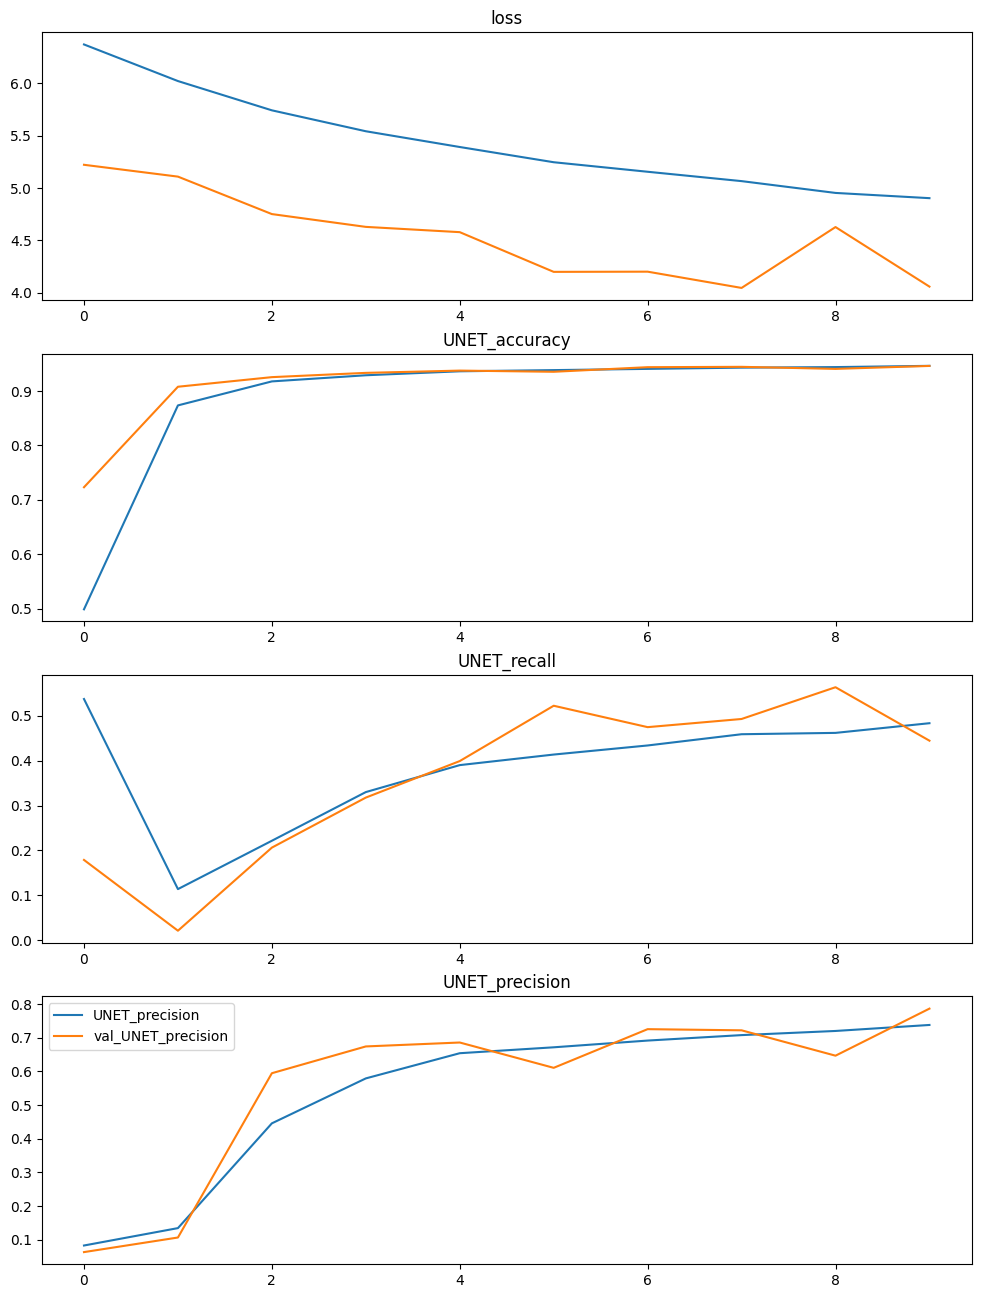

In [ ]:
metrics = ['loss', 'UNET_accuracy', 'UNET_recall', 'UNET_precision']
plt.figure(figsize = (12, 16))
for i in range(4):
    plt.subplot(4, 1, (i + 1))
    plt.plot(history.history['{}'.format(metrics[i])], label = '{}'.format(metrics[i]))
    plt.plot(history.history['val_{}'.format(metrics[i])], label = 'val_{}'.format(metrics[i]))
    plt.title('{}'.format(metrics[i]))
plt.legend()

In [ ]:
masks_pred, _ = m.predict(validDataset[0])

16/16 [==============================] - 2s 97ms/step


In [ ]:
masks_pred = (masks_pred >= 0.5).astype('int32')
np.unique(masks_pred), np.unique(validDataset[1])

(array([0, 1], dtype=int32), array([0, 1], dtype=int32))

In [ ]:
masks_pred = layers.Flatten()(masks_pred)
masks_pred  = np.reshape(masks_pred, -1)
masks_actual = layers.Flatten()(validDataset[1])
masks_actual  = np.reshape(masks_actual, -1)
masks_pred.shape, masks_actual.shape

((8192000,), (8192000,))

In [ ]:
print(classification_report(masks_actual, masks_pred))

              precision    recall  f1-score   support

           0       0.95      0.99      0.97   7538398
           1       0.79      0.44      0.57    653602

    accuracy                           0.95   8192000
   macro avg       0.87      0.72      0.77   8192000
weighted avg       0.94      0.95      0.94   8192000



In [ ]:
tn, fp, fn, tp = confusion_matrix(masks_actual, masks_pred).ravel()

In [ ]:
metrics = pd.DataFrame([accuracy_score(masks_actual, masks_pred)*100,
                        precision_score(masks_actual, masks_pred)*100,
                        recall_score(masks_actual, masks_pred)*100,
                        f1_score(masks_actual, masks_pred)*100,
                        (tn / (tn+fp))*100,
                        (2*tp/(2*tp + fp + fn))*100,
                        (tp/(tp + fn))*100],
                       index = ['Accuracy Score', 'Precision Score',
                                'Recall Score', 'F1 Score', 'specificity',
                                'dice Score', 'sensitivity'],
                       columns = ['Metrics For Validation Data'])
metrics.head(n= 8)

Metrics For Validation Data
Accuracy Score                     94.607336
Precision Score                    78.663614
Recall Score                       44.473089
F1 Score                           56.821627
specificity                        98.954128
dice Score                         56.821627
sensitivity                        44.473089

Visualize the Results

In [ ]:
def segmentation(data):
    masks_pred, _ = m.predict(data)
    masks_pred = np.array(masks_pred)
    masks_pred = (masks_pred >= 0.5).astype('int32')
    return masks_pred

In [ ]:
valid_masks = segmentation(validDataset[0])
valid_masks.shape

16/16 [==============================] - 1s 94ms/step


(500, 128, 128, 1)

In [ ]:
def draw(images, masks, y_pred):
  plt.figure(figsize = (12, 25))
  index = -1
  n = np.random.randint(y_pred.shape[0])
  for i in range(60):
    plt.subplot(10, 6, (i + 1))
    if index == -1:
      plt.imshow(images[n])
      plt.title('Image')
      index = 0
    elif index == 0:
      plt.imshow(images[n])
      plt.imshow(masks[n], alpha = 0.3, cmap = 'jet')
      plt.title('Original Mask')
      index = 1
    elif index == 1:
      plt.imshow(images[n])
      plt.imshow(np.reshape(y_pred[n], (128, 128)), alpha = 0.3, cmap = 'jet')
      plt.title('Predict Mask')
      index = -1
      n = np.random.randint(y_pred.shape[0])
  plt.legend()

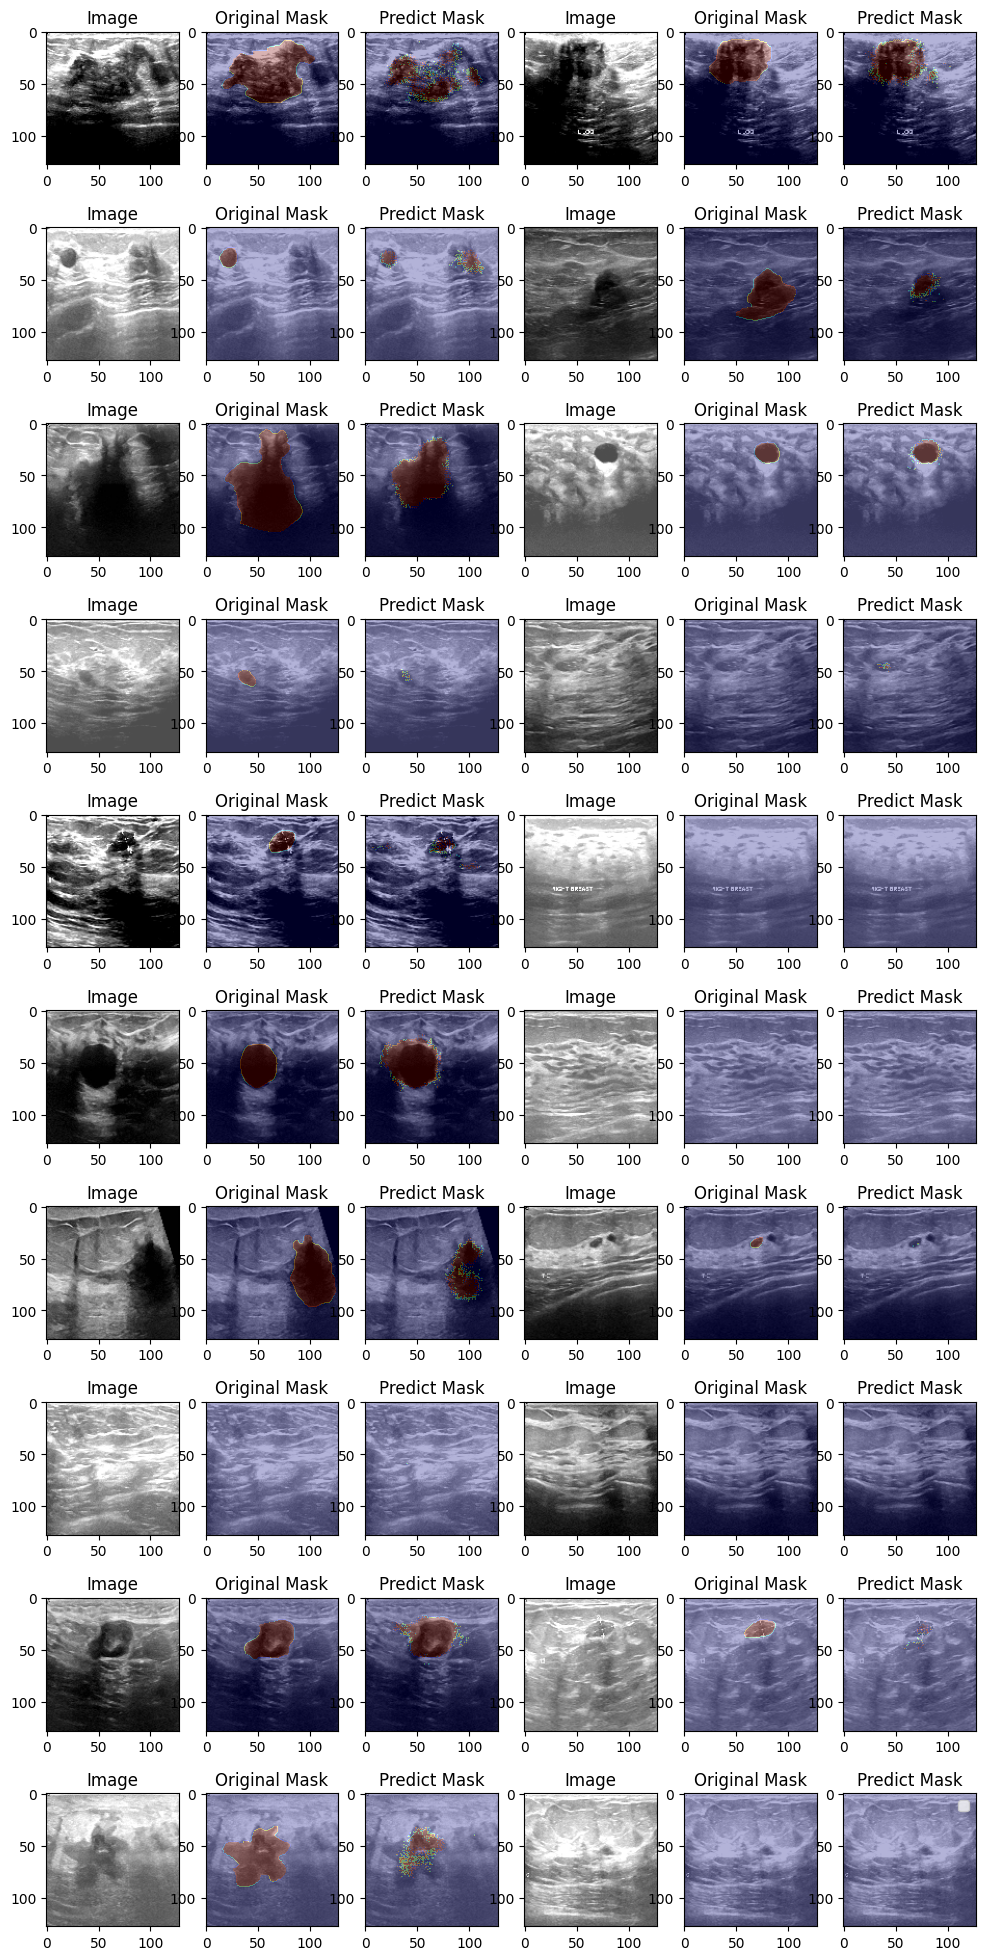

In [ ]:
draw(validDataset[0], validDataset[1], valid_masks)

In [ ]:
m.save('breast_cancer_segmentation.h5')

In [ ]:
%%shell
jupyter nbconvert --to html '/content/Cancer.ipynb'

[NbConvertApp] Converting notebook /content/Cancer.ipynb to html
[NbConvertApp] Writing 6756543 bytes to /content/Cancer.html
